# HSC photo-zs vs C3R2 spec-zs
The following notebook matches and compares HSC photometric redshifts in COSMOS to their spectroscopic redshifts from C3R2. 

In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column
from astropy.table import join, join_skycoord, unique, vstack
from astropy.io import fits

import matplotlib.pyplot as plt

import numpy as np

In [2]:
def load_catalog(file_path, file_name, isascii = False): 
    """
    Reads in and initializes variable containing catalog. 
    
    Parameters
    ----------
    file_path: (str)
        The path containing the catalog. 
    file_name : (str)
        The file name of the catalog. 
    isascii: (bool)
        Is it an ascii file or not? Read-in depends on it! 
        
    Returns
    -------
    catalog : (astropy.Table)
        An astropy Table containing the catalog. 
    """
    if isascii == True:
        catalog = Table.read(f'{file_path}/{file_name}', data_start = 40, format = 'ascii')
        
    else: 
        catalog = Table.read(f'{file_path}/{file_name}')
        
    return catalog

def vertical_stack(catalog_1, catalog_2, id_1, id_2): 
    """ 
    Stacks two catalogs vertically, retaining origin information. 
    
    Parameters 
    ----------
    catalog_1: (astropy.Table)
        The first catalog in the stack.
    catalog_2: (astropy.Table)
        The second catalog in the stack. 
    id_1: (str)
        The identifying information for the first catalog. (i.e., catalog name?)
    id_2: (str)
        The identifying information for the second catalog. 
        
    Returns
    -------
        
    """
    
    # add a column to both catalog 1 and catalog 2 to store identifiers
    # initialize columns
    col_1 = Column(name = 'catalog_name', data = np.full(len(catalog_1), str(id_1))) 
    col_2 = Column(name = 'catalog_name', data = np.full(len(catalog_2), str(id_2)))
    
    # add columns to catalogs
    catalog_1.add_column(col_1)
    catalog_2.add_column(col_2)
    
    # vertically stack catalogs 
    stacked_catalog = vstack((catalog_1, catalog_2))
    
    return stacked_catalog

def convert_coordinates(catalog): 
    """
    Converts the Ra and Dec in the catalog from (hourangle, degree) to (degree, degree). 
    
    Parameters
    ----------
    catalog: (astropy.Table)
        Catalog requiring conversion. 
    
    Returns
    -------
    catalog: (astropy.Table)
        Catalog with additional columns holding converted positions. 
    """

    ra_h = np.array(catalog['RAh'])
    ra_m = np.array(catalog['RAm'])
    ra_s = np.array(catalog['RAs'])
    dec_sign = np.array(catalog['DE-'])
    dec_d = np.array(catalog['DEd'])
    dec_m = np.array(catalog['DEm'])
    dec_s = np.array(catalog['DEs'])
    coords_list = [] 

    # store coord into SkyCoord for easier conversion to deg + comparison with HSC 
    coords_list = [SkyCoord(f'{ra_h[i]}h{ra_m[i]}m{ra_s[i]}s', f'{dec_sign[i]}{dec_d[i]}d{dec_m[i]}m{dec_s[i]}s', unit = (u.hourangle, u.deg)) for i, obj in enumerate(catalog)]
    col_ra = [Column(name = 'RAd', data = coords_list[i].ra*u.deg/u.deg) for i, obj in enumerate(catalog)]
    col_dec = [Column(name = 'DEd', data = coords_list[i].dec*u.deg/u.deg) for i, obj in enumerate(catalog)]

    # add columns to catalog 
    catalog.add_column(col_ra*u.deg, name = 'RAdeg')
    catalog.add_column(col_dec*u.deg, name = 'DEdeg')

    return catalog

def get_ra_dec(catalog, ra_str, dec_str): 
    """
    Creates list of RA and Decs for the input catalog.
    
    Parameters 
    ----------
    catalog : (astropy.Table)
        An astropy Table containing the catalog. 
    ra_str : (str)
        String used for RA header
    dec_str : str
        String used for the Dec header
        
    Returns
    -------
    ra : (list)
        List containing the RAs of objects.
    dec : (list)
        List containing the Decs of the objects. 
    
    """
    ra = list(catalog[ra_str])
    dec = list(catalog[dec_str])
    
    return(ra, dec)

def create_sky_coord(ra, dec, deg = True, ra_u = None, dec_u = None): 
    """
    Creates SkyCoord object for match_catalogs function. 
    
    Parameters 
    ----------
    ra : (list) or (str)
        List containing RAs of the objects. 
        Or RA of the object.
    dec : (list) or (str)
        List containing Decs of the objects. 
        Or Dec of the object. 
    deg : (bool)
        Is the coordinate already in degrees?
    ra_u : (astropy.unit) or (None)
        RA unit.
    dec_u : (astropy.unit) or (None)
        Dec unit. 
        
    
    Returns 
    -------
    sky_coord : (astropy.coordinates.SkyCoord)
        SkyCoord object containing positional information, 
        including units and separation (dimensionless, set to 1).
    """
    if deg == True: 
        sky_coord = SkyCoord(ra*u.deg, dec*u.deg)
    else: 
        sky_coord = SkyCoord(ra, dec, unit = (ra_u, dec_u))
    
    return sky_coord

def match_catalogs(catalog1_coord, catalog2_coord): 
    """
    Matches two catalogs based on coordinates. 
    Note: Assumes coords are in RA and Dec (degrees). 
    
    Parameters 
    ----------
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2
        
    Return
    ------
    idx : (list)
        Indices into catalog2_coord that are the closest objects 
        to each of the coordinates in catalog1_coord
    d2d : (list)
        On-sky distances between them 
    d3d : (list)
        3D distances between them
    """
    idx, d2d, d3d = catalog1_coord.match_to_catalog_sky(catalog2_coord)
    
    return idx, d2d, d3d

def get_matches(max_sep, catalog1_coord, catalog2_coord, catalog1, catalog2): 
    """
    Matches two catalogs based on coordinates using match_catalogs. 
    Prints matches considering separation constraint. 
    
    Parameters 
    ----------
    max_sep : (float)
        Maximum separation to be considered a match (arcsec)
    catalog1_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 1
    catalog2_coord : (list)
        SkyCoord object containing positional information, 
        including units and deparation (dimensionless, set to 1), 
        for catalog 2    
    
    Return
    ------
    catalog1_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog1
    catalog2_matches : (list)
        List containing matched sources separated by less than 
        max_sep in catalog2
    """
    # add units to max separation 
    max_sep = max_sep * u.arcsec
    idx, d2d, d3d = match_catalogs(catalog1_coord, catalog2_coord)
    separation_constraint = d2d < max_sep 
    
    catalog1_matches = catalog1[separation_constraint]
    catalog2_matches = catalog2[idx[separation_constraint]]
    
    return catalog1_matches, catalog2_matches

In [3]:
# open up catalogs

# path to DESI SOM data
data_path = '/Users/diana/Research/DESI-SOM/data'

In [4]:
# load catalogs -- note: might need to rerun if updating columns

# photoz
hsc_photoz_9812_cat = load_catalog(data_path, 'HSC/pdf-s17a_wide-9812.cat.fits', isascii = False)
hsc_photoz_9813_cat = load_catalog(data_path, 'HSC/pdf-s17a_wide-9813.cat.fits', isascii = False)

# targets photoz (positional info)
hsc_pos_9812_cat = load_catalog(data_path, 'HSC/target_wide_s17a_9812.fits', isascii = False)
hsc_pos_9813_cat = load_catalog(data_path, 'HSC/target_wide_s17a_9813.fits', isascii = False)
hsc_pos_9812_cat.rename_column('object_id', 'ID')
hsc_pos_9813_cat.rename_column('object_id', 'ID')

# speczs
c3r2_specz_DR1_DR2_cat = load_catalog(data_path, 'C3R2/c3r2_DR1+DR2_2019april11.txt', isascii = True)
c3r2_specz_DR3_cat = load_catalog(data_path, 'C3R2/C3R2-DR3-18june2021.txt', isascii = True)

In [5]:
# create joint photoz + positions table
hsc_photoz_pos_9812_cat = join(hsc_photoz_9812_cat, hsc_pos_9812_cat, keys='ID')
hsc_photoz_pos_9813_cat = join(hsc_photoz_9813_cat, hsc_pos_9813_cat, keys='ID')

# create joint catalog retaining origin catalog identifiers 
hsc_photoz_cat = vertical_stack(hsc_photoz_pos_9812_cat, hsc_photoz_pos_9813_cat, id_1 = 'target_wide_s17a_9812.fits', id_2 = 'target_wide_s17a_9813.fits')

In [6]:
# convert C3R2 coords into decimal degrees for matching
c3r2_specz_DR1_DR2_pos_cat = convert_coordinates(c3r2_specz_DR1_DR2_cat)
c3r2_specz_DR3_pos_cat = convert_coordinates(c3r2_specz_DR3_cat)

# create joint DR1, DR2, DR3 catalog retaining origin catalog identifiers
c3r2_specz_cat = vertical_stack(c3r2_specz_DR1_DR2_pos_cat, c3r2_specz_DR3_pos_cat, id_1 = 'c3r2_DR1+DR2_2019april11.txt', id_2 = 'C3R2-DR3-18june2021.txt');
#!!!MergeConflictWarning: In merged column 'imag' the 'description' attribute does not match (i-band AB magnitude, ?=-1.0 != i-band AB magnitude).  
#!!! Using i-band AB magnitude for merged output [astropy.utils.metadata] (output)

In [7]:
# create SkyCoord for each catalog (redundant?)
# obtain ra and dec for each catalog
hsc_photoz_cat_ra, hsc_photoz_cat_dec = get_ra_dec(hsc_photoz_cat, 'ra', 'dec')
c3r2_specz_cat_ra, c3r2_specz_cat_dec = get_ra_dec(c3r2_specz_cat, 'RAdeg', 'DEdeg')

In [8]:
# create SkyCoord object for each catalog
hsc_photoz_cat_sky_coord = create_sky_coord(hsc_photoz_cat_ra, hsc_photoz_cat_dec) 
c3r2_specz_cat_sky_coord = create_sky_coord(c3r2_specz_cat_ra, c3r2_specz_cat_dec) 

In [62]:
# find matches 
photoz_specz_idx, photoz_specz_d2d, photoz_specz_d3d = match_catalogs(hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord)

# print matches
# obtain matches within 1 arcsec
photoz_specz_matches, specz_photoz_matches = get_matches(1, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches)} matches in HSC (wide) x C3R2.')

There are 2748 matches in HSC (wide) x C3R2.


Text(0, 0.5, 'photo-z')

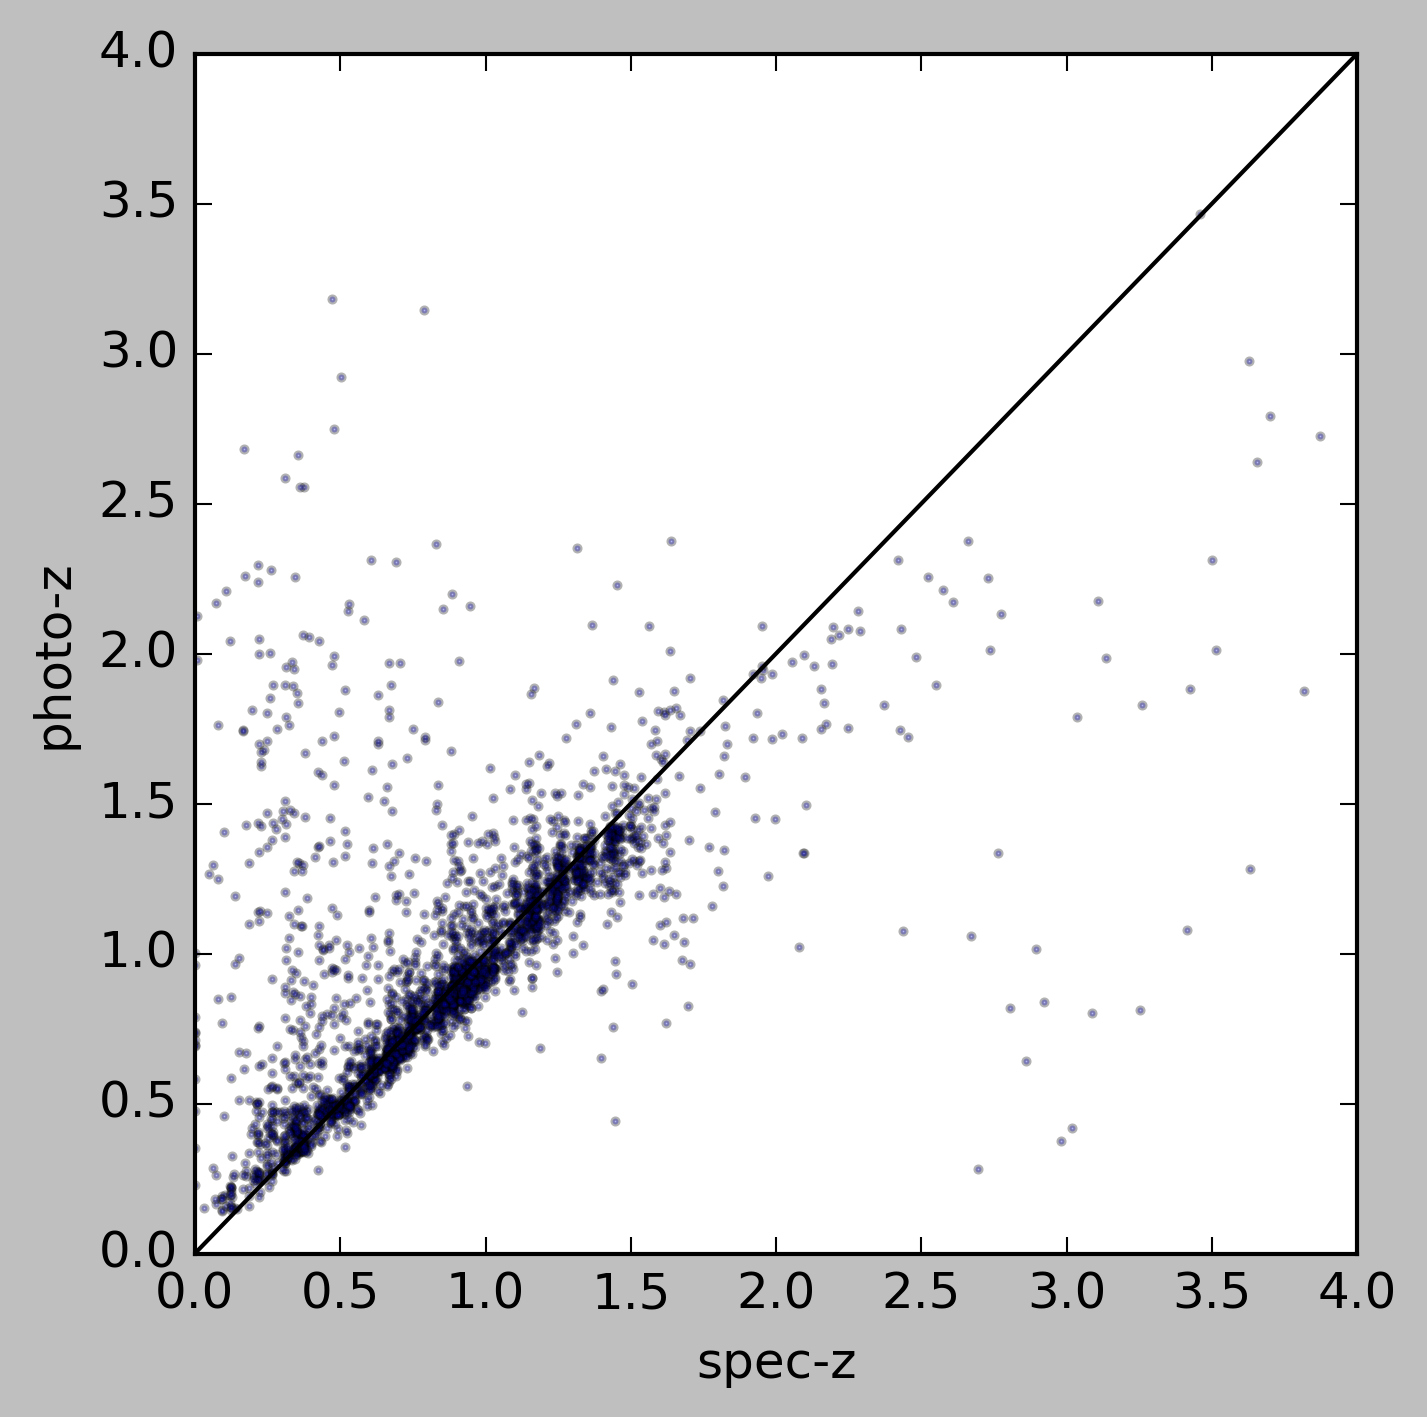

In [31]:
# plot photoz vs specz 
# set style
plt.style.use('classic')

fig, ax = plt.subplots(figsize = (5,5), dpi = 300) # make figure larger and more HD

# plot data
plt.scatter(specz_photoz_matches['zspec'], photoz_specz_matches['PHOTOZ_MEAN'], s = 2, alpha = 0.3)

# plot x = y 
points = np.linspace(0, 4, 50)
plt.plot(points, points, c = 'k')

plt.xlim((0,4))
plt.ylim((0,4))

plt.xlabel('spec-z')
plt.ylabel('photo-z')

#plt.savefig('photo-z_vs_spec-z.png')

# Dependency on matching radius? 
Let's visualize the same relationship at different matching radius sizes. 

In [33]:
# print matches (now a bit redundant, as all is contained in plotting cell below.)
# obtain matches within...

# 0.05 arcsec
radius = 0.05 # default unit arcsec
photoz_specz_matches_005, specz_photoz_matches_005 = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches_005)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')

# 0.1 arcsec
radius = 0.1 # default unit arcsec
photoz_specz_matches_01, specz_photoz_matches_01 = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches_01)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')

# 0.5 arcsec
radius = 0.5 # default unit arcsec
photoz_specz_matches_05, specz_photoz_matches_05 = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches_05)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')

# 1 arcsec
radius = 1.0 # default unit arcsec
photoz_specz_matches_1, specz_photoz_matches_1 = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches_1)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')

# 2 arcsec
radius = 2.0 # default unit arcsec
photoz_specz_matches_2, specz_photoz_matches_2 = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
print(f'There are {len(photoz_specz_matches_2)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')

There are 483 matches in HSC (wide) x C3R2 using a 0.05 arcsec matching radius.
There are 1319 matches in HSC (wide) x C3R2 using a 0.1 arcsec matching radius.
There are 2641 matches in HSC (wide) x C3R2 using a 0.5 arcsec matching radius.
There are 2748 matches in HSC (wide) x C3R2 using a 1.0 arcsec matching radius.
There are 3470 matches in HSC (wide) x C3R2 using a 2.0 arcsec matching radius.


There are 24 matches in HSC (wide) x C3R2 using a 0.01 arcsec matching radius.
There are 483 matches in HSC (wide) x C3R2 using a 0.05 arcsec matching radius.
There are 1319 matches in HSC (wide) x C3R2 using a 0.1 arcsec matching radius.
There are 2641 matches in HSC (wide) x C3R2 using a 0.5 arcsec matching radius.
There are 2748 matches in HSC (wide) x C3R2 using a 1.0 arcsec matching radius.


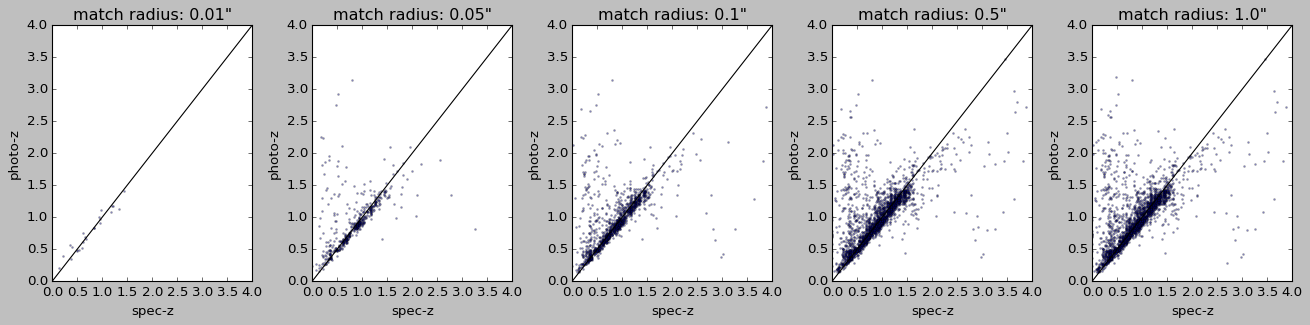

In [97]:
# understanding how the matches change with matching radius 
match_radius = [0.01, 0.05, 0.1, 0.5, 1.0] # arcsec
fig,ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
plt_ind = np.arange(5) + 151
for radius, ind in zip(match_radius, plt_ind):
    plt.subplot(ind);
    
    # get matches
    photoz_specz_matches, specz_photoz_matches = get_matches(radius, hsc_photoz_cat_sky_coord, c3r2_specz_cat_sky_coord, hsc_photoz_cat, c3r2_specz_cat)
    plt.scatter(specz_photoz_matches['zspec'], photoz_specz_matches['PHOTOZ_MEAN'], s = 2, alpha = 0.3)
    print(f'There are {len(photoz_specz_matches)} matches in HSC (wide) x C3R2 using a {radius} arcsec matching radius.')
    
    # plot x = y 
    points = np.linspace(0, 4, 50)
    plt.plot(points, points, c = 'k')
    
    plt.title('match radius: ' + str(radius) + '\"')
    plt.xlabel('spec-z')
    plt.ylabel('photo-z')
    
    plt.xlim((0,4))
    plt.ylim((0,4))

    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
#plt.show()
plt.savefig('photo-z_vs_spec-z_matching_radius.png')

In [42]:
# Let's visualize the distribution of 2D on-sky distances between matches

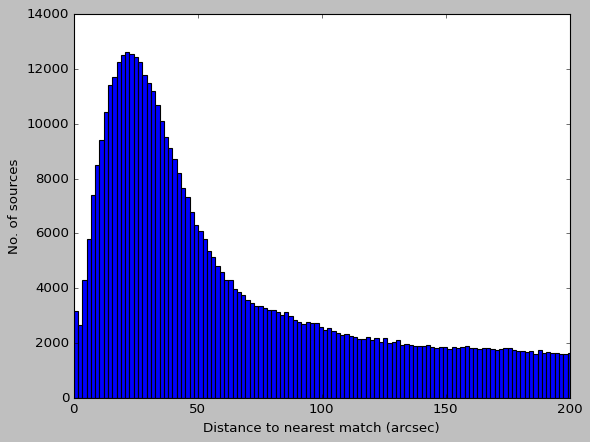

In [94]:
# plot histogram of on-sky distances between matches
# convert to decimal degrees for convenience
photoz_specz_d2d_arcsec = (photoz_specz_d2d).to(u.arcsec)

# plot
plt.hist(np.array(photoz_specz_d2d_arcsec), bins = 1000); 
plt.xlabel('Distance to nearest match (arcsec)')
plt.ylabel('No. of sources')
plt.xlim((0,200))

plt.savefig('nearest_match_full_hist.png')
# wouldn't this be more indicative of every object having a neighbor within 25 arcsec? 

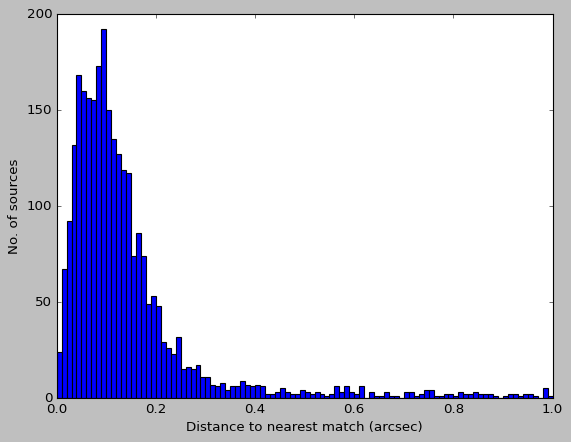

In [96]:
# plot
plt.hist(np.array(photoz_specz_d2d_arcsec), bins = 100, range = (0, 1)); 
plt.xlabel('Distance to nearest match (arcsec)')
plt.ylabel('No. of sources')
plt.xlim((0 , 1))

#plt.savefig('nearest_match_zoomed_hist.png')